# 简单的卷积网络实现

https://github.com/oreilly-japan/deep-learning-from-scratch/blob/master/ch07/simple_convnet.py

In [2]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 为导入父目录中的文件而进行的设置
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class SimpleConvNet:
    """简单的ConvNet
    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 输入的大小（MNIST数据的输入大小为784）
    hidden_size_list : 隐藏层神经元数量列表（e.g. [100, 100, 100]）
    output_size : 输出的大小（MNIST数据的输出大小为10）
    activation : 'relu' or 'sigmoid'
    weight_init_std : 设置权重的标准差（e.g. 0.01）
        使用'relu'或'he'时，指定为「He的初始值」
        使用'sigmoid'或'xavier'时，指定为「Xavier的初始值」
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 权重初始化
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 生成层
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """求损失函数
           参数x为输入数据、t为监督数据的标签
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """求梯度（数值微分）
        Parameters
        ----------
        x : 输入数据
        t : 监督数据的标签
        Returns
        -------
        保存有各层梯度的字典变量
            grads['W1']、grads['W2']、...为各层的权重
            grads['b1']、grads['b2']、...为各层的偏置
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """求梯度（误差反向传播法）
        Parameters
        ----------
        x : 输入数据
        t : 监督数据的标签
        Returns
        -------
        保存有各层梯度的字典变量
            grads['W1']、grads['W2']、...为各层的权重
            grads['b1']、grads['b2']、...为各层的偏置
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 设置
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

# 训练卷积网络

https://github.com/oreilly-japan/deep-learning-from-scratch/blob/master/ch07/train_convnet.py

train loss:2.298363787083355
=== epoch:1, train acc:0.236, test acc:0.242 ===
train loss:2.296706295857967
train loss:2.292691633503392
train loss:2.283486646299622
train loss:2.2712700076618564
train loss:2.2683018929074716
train loss:2.245100547565853
train loss:2.2322225204352915
train loss:2.1991232390015876
train loss:2.1727214016885195
train loss:2.131718501610873
train loss:2.127501808556071
train loss:2.0289674452738438
train loss:1.9551985141533075
train loss:1.9742221542354057
train loss:1.9149409338213055
train loss:1.8301853280415825
train loss:1.7530020867317313
train loss:1.6647660060671734
train loss:1.601356028969523
train loss:1.5679587230348904
train loss:1.4159968499373827
train loss:1.3169464052797568
train loss:1.2086799726708408
train loss:1.242231169600962
train loss:1.0944993978961328
train loss:1.005298101248119
train loss:1.042028790923519
train loss:1.0455733782610912
train loss:0.8306126466285181
train loss:0.8416701810830282
train loss:0.7874273039678238
tr

train loss:0.2589129122172732
train loss:0.162236678305782
train loss:0.1465414594767902
train loss:0.2607771342947665
train loss:0.26365685578634496
train loss:0.21342857932053505
train loss:0.16173510261501522
train loss:0.21744686805112515
train loss:0.2513207942136274
train loss:0.15552116438257538
train loss:0.2569810946368218
train loss:0.21920676187214827
train loss:0.09200889275801635
train loss:0.14614299390323204
train loss:0.22191125720633537
train loss:0.2267114343839381
train loss:0.11678994673482845
train loss:0.34108313551352815
train loss:0.17426178007735643
train loss:0.27874995391253826
train loss:0.13216643458261168
train loss:0.19409784332765517
train loss:0.23895014341809886
train loss:0.1339855160020341
train loss:0.345054321391781
train loss:0.17454927304604695
train loss:0.17639362141232492
train loss:0.23469079020563288
train loss:0.14699044516076448
train loss:0.2337049835131188
train loss:0.16597438539501583
train loss:0.1948590446619291
train loss:0.13415290

train loss:0.11035769641299797
train loss:0.11564225016294692
train loss:0.16940180230802773
train loss:0.1089501633281955
train loss:0.1254712282190877
train loss:0.15559382586658102
train loss:0.04265389809342625
train loss:0.1235317708471172
train loss:0.2111467424059652
train loss:0.08581750351318358
train loss:0.06732561779345562
train loss:0.07553519369524685
train loss:0.11891045931924417
train loss:0.10107521274056828
train loss:0.09146939665171198
train loss:0.07102665580097742
train loss:0.08610981805256086
train loss:0.06847414165908443
train loss:0.10361732677026086
train loss:0.08597233820396025
train loss:0.04777052161264324
train loss:0.0545511317064051
train loss:0.07153014425887706
train loss:0.08898243636535375
train loss:0.13523610800735716
train loss:0.06128331459033694
train loss:0.04361672127039994
train loss:0.060184590812242374
train loss:0.06982835800597037
train loss:0.1041844420214919
train loss:0.08015925256074027
=== epoch:12, train acc:0.96, test acc:0.937

train loss:0.06655199730948627
train loss:0.016422426996247453
train loss:0.07842796366137143
train loss:0.10832190128905898
train loss:0.025993356367930463
train loss:0.12290254434842461
train loss:0.03146163211997479
train loss:0.038798978469390503
train loss:0.024573474044901022
train loss:0.016839253780020033
train loss:0.05233039716066787
train loss:0.01374982454522698
train loss:0.03352671997861438
train loss:0.08812714279944489
train loss:0.12860681151682984
train loss:0.05049432178646271
train loss:0.03808411927617014
train loss:0.04472016768053562
train loss:0.09153074366722817
train loss:0.036394998078866043
train loss:0.06267111811186266
train loss:0.033884989878451593
train loss:0.11113652932740728
train loss:0.04427707624955467
train loss:0.017354029072004885
=== epoch:17, train acc:0.979, test acc:0.951 ===
train loss:0.04789742620145846
train loss:0.10574011821440125
train loss:0.09101259123347459
train loss:0.028778440655208647
train loss:0.011400664983457202
train loss

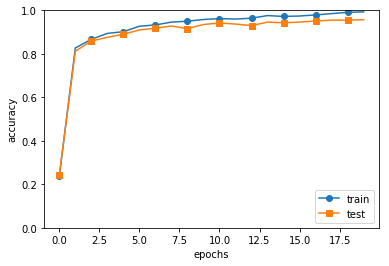

In [5]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 为导入父目录中的文件而进行的设置
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
#from simple_convnet import SimpleConvNet
from common.trainer import Trainer

# 读入数据
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 如果处理耗时，则减少数据
x_train, t_train = x_train[:5000], t_train[:5000]
x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 保存参数
network.save_params("params.pkl")
print("Saved Network Parameters!")

# 绘制图形
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()


# 梯度检查

https://github.com/oreilly-japan/deep-learning-from-scratch/blob/master/ch07/gradient_check.py

In [7]:
# coding: utf-8
import numpy as np
# from simple_convnet import SimpleConvNet

network = SimpleConvNet(input_dim=(1,10, 10), 
                        conv_param = {'filter_num':10, 'filter_size':3, 'pad':0, 'stride':1},
                        hidden_size=10, output_size=10, weight_init_std=0.01)

X = np.random.rand(100).reshape((1, 1, 10, 10))
T = np.array([1]).reshape((1,1))

grad_num = network.numerical_gradient(X, T)
grad = network.gradient(X, T)

for key, val in grad_num.items():
    print(key, np.abs(grad_num[key] - grad[key]).mean())

W1 5.935449328823674e-07
b1 6.069060608834397e-10
W2 5.478828239380243e-11
b2 5.345778755017965e-05
W3 1.32725632003911e-10
b3 1.7990897208247648e-07


# 权重可视化

https://github.com/oreilly-japan/deep-learning-from-scratch/blob/master/ch07/visualize_filter.py

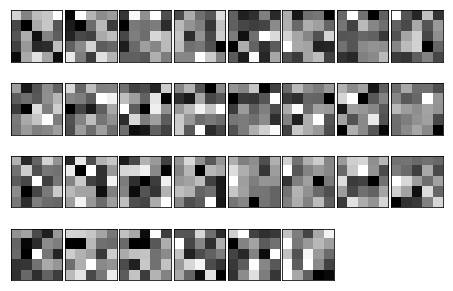

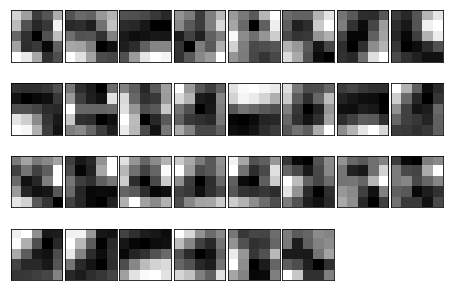

In [8]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt
# from simple_convnet import SimpleConvNet

def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
#  随机初始化后的权重
filter_show(network.params['W1'])

# 学习后的权重
network.load_params("params.pkl")
filter_show(network.params['W1'])

# 应用滤波器

https://github.com/oreilly-japan/deep-learning-from-scratch/blob/master/ch07/apply_filter.py

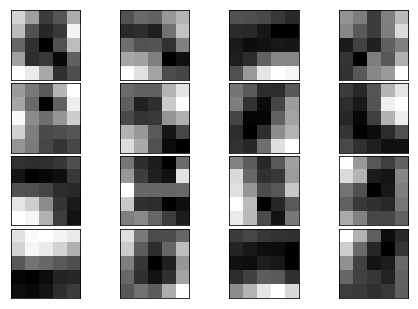

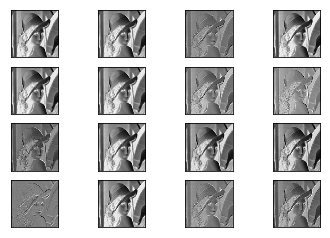

In [11]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 为导入父目录中的文件而进行的设置
import numpy as np
import matplotlib.pyplot as plt
# from simple_convnet import SimpleConvNet
from matplotlib.image import imread
from common.layers import Convolution

def filter_show(filters, nx=4, show_num=16):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(show_num / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(show_num):
        ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')


network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)

# 学习后的权重
network.load_params("params.pkl")

filter_show(network.params['W1'], 16)

img = imread('dataset/lena_gray.png')
img = img.reshape(1, 1, *img.shape)

fig = plt.figure()

w_idx = 1

for i in range(16):
    w = network.params['W1'][i]
    b = 0  # network.params['b1'][i]

    w = w.reshape(1, *w.shape)
    #b = b.reshape(1, *b.shape)
    conv_layer = Convolution(w, b) 
    out = conv_layer.forward(img)
    out = out.reshape(out.shape[2], out.shape[3])
    
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    ax.imshow(out, cmap=plt.cm.gray_r, interpolation='nearest')

plt.show()